<a href="https://colab.research.google.com/github/dillonkoh89/GA-Capstone/blob/main/Capstone_Model_Maker_Object_Detection_Loaded.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q tensorflow==2.4.3

     |████████████████████████████████| 394.5 MB 365 bytes/s 
     |████████████████████████████████| 2.9 MB 42.9 MB/s 
     |████████████████████████████████| 462 kB 33.9 MB/s 
     |████████████████████████████████| 3.8 MB 33.7 MB/s 


In [ ]:
# !pip list

In [2]:
import numpy as np
import os

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

In [3]:
import cv2
from PIL import Image

In [4]:
#mount drive
from google.colab import drive
drive.mount('/content/drive/')

# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/drive/My\ Drive/ /mydrive

#list contents in your drive
!ls /mydrive

Mounted at /content/drive/
'20211012 - GraphExercise.gdoc'
'20211014 - SpatialExercise (1).gsheet'
'20211014 - SpatialExercise.gsheet'
'20211022 - Test.gsheet'
'20211106 - Image Classification.gslides'
'Capstone - Model Maker Object Detection.ipynb'
'Capstone Project Proposal.gslides'
'Classification of Subreddit Posts.gslides'
 classification.zip
'Colab Notebooks'
'Copy of Architecture Design Development PowerPoint Template #1386.gslides'
 customTF1
 dad.docx
 DSIF2_Project4_Nov2.gslides
 HR2002.docx
 log
 model.tflite
'My Drive'
 TFlite
 training
'Untitled document.gdoc'
'Untitled presentation - Pie chart 1.gsheet'
'Your big idea.gslides'


In [12]:
with open('/mydrive/TFlite/colab_models/tflite2/model.tflite', 'rb') as fid:
    tflite_model = fid.read()
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

In [13]:
# Read the label.txt
with open('/mydrive/TFlite/colab_models/tflite1/labels.txt', 'rb') as file:
    lines = []
    for line in file:
        lines.append(line.rstrip().decode())

# Load the labels into a list
# classes = ['helmet', 'person', 'safety vest']
classes = lines
print(classes)

['helmet', 'person', 'safety vest']


In [8]:
import cv2

from PIL import Image

# Define a list of colors for visualization
COLORS = np.random.randint(0, 255, size=(len(classes), 3), dtype=np.uint8)

def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.io.read_file(image_path)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  return resized_img, original_image


def set_input_tensor(interpreter, image):
  """Set the input tensor."""
  tensor_index = interpreter.get_input_details()[0]['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  input_tensor[:, :] = image


def get_output_tensor(interpreter, index):
  """Retur the output tensor at the given index."""
  output_details = interpreter.get_output_details()[index]
  tensor = np.squeeze(interpreter.get_tensor(output_details['index']))
  return tensor


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""
  # Feed the input image to the model
  set_input_tensor(interpreter, image)
  interpreter.invoke()

  # Get all outputs from the model
  boxes = get_output_tensor(interpreter, 0)
  classes = get_output_tensor(interpreter, 1)
  scores = get_output_tensor(interpreter, 2)
  count = int(get_output_tensor(interpreter, 3))

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
  return results


def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

  # Load the input image and preprocess it
  preprocessed_image, original_image = preprocess_image(
      image_path,
      (input_height, input_width)
    )

  # Run object detection on the input image
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

  # Plot the detection results on the input image
  original_image_np = original_image.numpy().astype(np.uint8)
  for obj in results:
    # Convert the object bounding box from relative coordinates to absolute
    # coordinates based on the original image resolution
    ymin, xmin, ymax, xmax = obj['bounding_box']
    xmin = int(xmin * original_image_np.shape[1])
    xmax = int(xmax * original_image_np.shape[1])
    ymin = int(ymin * original_image_np.shape[0])
    ymax = int(ymax * original_image_np.shape[0])

    # Find the class index of the current object
    class_id = int(obj['class_id'])

    # Draw the bounding box and label on the image
    color = [int(c) for c in COLORS[class_id]]
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
    # Make adjustments to make the label visible for all objects
    y = ymin - 15 if ymin - 15 > 15 else ymin + 15
    label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
    cv2.putText(original_image_np, label, (xmin, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  # Return the final image
  original_uint8 = original_image_np.astype(np.uint8)
  return original_uint8, results

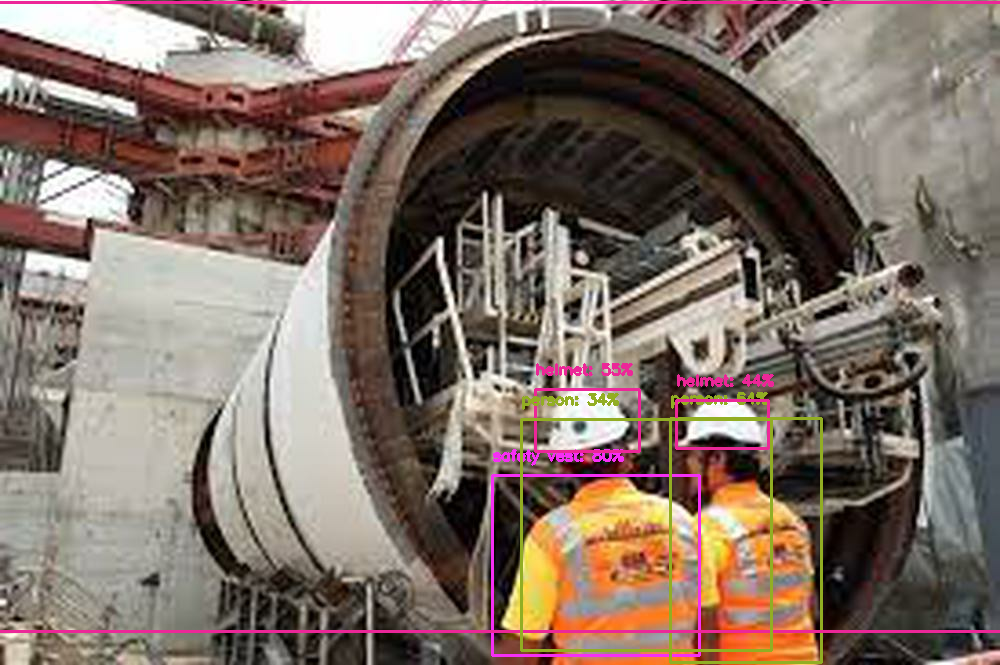

In [35]:
INPUT_IMAGE = '/mydrive/TFlite/test/images/pos_3490.jpg'
DETECTION_THRESHOLD = 0.3 

#This script will resize an image (somepic.jpg) using PIL (Python Imaging Library) to a width of 300 pixels and a height proportional to the new width. It does this by determining what percentage 300 pixels is of the original width (img.size[0]) and then multiplying the original height (img.size[1]) by that percentage. Change "basewidth" to any other number to change the default width of your images.
basewidth = 1000
img = Image.open(INPUT_IMAGE)
wpercent = (basewidth/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
img = img.resize((basewidth,hsize), Image.ANTIALIAS)
img.save('/mydrive/TFlite/test/images/temp_resize.jpg')

temp_file = '/mydrive/TFlite/test/images/temp_resize.jpg'

# Run inference and draw detection result on the local copy of the original file
detection_result_image, results = run_odt_and_draw_results(
    temp_file, 
    interpreter, 
    threshold=DETECTION_THRESHOLD
)

# Show the detection result
Image.fromarray(detection_result_image)


In [16]:
print(results)

[{'bounding_box': array([0.359848  , 0.0420189 , 0.81919575, 0.17312858], dtype=float32), 'class_id': 1.0, 'score': 0.69921875}, {'bounding_box': array([0.42580283, 0.50683594, 0.5697342 , 0.6078955 ], dtype=float32), 'class_id': 2.0, 'score': 0.5703125}, {'bounding_box': array([0.3345405 , 0.6611732 , 0.39594847, 0.7601675 ], dtype=float32), 'class_id': 0.0, 'score': 0.5546875}, {'bounding_box': array([0.38481584, 0.16959569, 0.7884191 , 0.27169117], dtype=float32), 'class_id': 1.0, 'score': 0.54296875}, {'bounding_box': array([0.3351221 , 0.7857342 , 0.38599664, 0.85220337], dtype=float32), 'class_id': 0.0, 'score': 0.4453125}, {'bounding_box': array([0.35460073, 0.31567752, 0.7547379 , 0.41689622], dtype=float32), 'class_id': 1.0, 'score': 0.4375}, {'bounding_box': array([0.38258475, 0.76559436, 0.9613268 , 0.9197686 ], dtype=float32), 'class_id': 1.0, 'score': 0.4296875}, {'bounding_box': array([0.39466637, 0.49306682, 0.83084744, 0.6034032 ], dtype=float32), 'class_id': 1.0, 'scor

In [36]:
DETECTION_THRESHOLD = 0.5
IMAGE_DIR = '/mydrive/TFlite/test/images/'
IMAGE_PATHS = []
for file in os.listdir(IMAGE_DIR):
    if file.endswith(".jpg") or file.endswith(".png"):
        IMAGE_PATHS.append(os.path.join(IMAGE_DIR, file))
for image_path in IMAGE_PATHS:
    
  #This script will resize an image (somepic.jpg) using PIL (Python Imaging Library) to a width of 300 pixels and a height proportional to the new width. It does this by determining what percentage 300 pixels is of the original width (img.size[0]) and then multiplying the original height (img.size[1]) by that percentage. Change "basewidth" to any other number to change the default width of your images.
  basewidth = 1000
  img = Image.open(image_path)
  wpercent = (basewidth/float(img.size[0]))
  hsize = int((float(img.size[1])*float(wpercent)))
  img = img.resize((basewidth,hsize), Image.ANTIALIAS)
  img.save('/mydrive/TFlite/test/images/temp_resize.jpg')

  temp_file = '/mydrive/TFlite/test/images/temp_resize.jpg'

  # Run inference and draw detection result on the local copy of the original file
  detection_result_image, results = run_odt_and_draw_results(
      temp_file, 
      interpreter, 
      threshold=DETECTION_THRESHOLD
  )

  # Show the detection result
  Image.fromarray(detection_result_image)